In [1]:
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import eda_helper_functions

# 2. Read the Training Data

In [2]:
file_path = r"C:\Users\RITHIK\Flight Prices Prediction with AWS Sagemaker\Data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-27,Mumbai,Hyderabad,21:20:00,22:50:00,90,0.0,No info,2227
1,Jet Airways,2019-03-03,Delhi,Cochin,09:55:00,18:50:00,535,1.0,No info,18550
2,Jet Airways,2019-05-18,Kolkata,Banglore,16:30:00,18:15:00,1545,1.0,In-flight meal not included,10844
3,Indigo,2019-06-01,Mumbai,Hyderabad,06:25:00,07:55:00,90,0.0,No info,4049
4,Indigo,2019-03-01,Mumbai,Hyderabad,09:10:00,10:40:00,90,0.0,No info,13999
...,...,...,...,...,...,...,...,...,...,...
635,Jet Airways,2019-03-03,Banglore,New Delhi,05:45:00,05:05:00,1400,1.0,In-flight meal not included,11087
636,Jet Airways,2019-06-09,Delhi,Cochin,19:30:00,04:25:00,535,2.0,No info,13014
637,Multiple Carriers,2019-06-15,Delhi,Cochin,18:15:00,01:30:00,435,1.0,No info,13377
638,Jet Airways,2019-05-12,Kolkata,Banglore,09:35:00,09:45:00,1450,1.0,No info,14151


In [3]:
train.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
dtype: object

In [4]:
train = train.assign(**{
    col: pd.to_datetime(train.loc[:, col], dayfirst=True, format="mixed")
    for col in ["date_of_journey", "dep_time", "arrival_time"]
    })
train.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
dtype: object

# 3. High-level Summary of Data

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          640 non-null    object        
 1   date_of_journey  640 non-null    datetime64[ns]
 2   source           640 non-null    object        
 3   destination      640 non-null    object        
 4   dep_time         640 non-null    datetime64[ns]
 5   arrival_time     640 non-null    datetime64[ns]
 6   duration         640 non-null    int64         
 7   total_stops      640 non-null    float64       
 8   additional_info  640 non-null    object        
 9   price            640 non-null    int64         
dtypes: datetime64[ns](3), float64(1), int64(2), object(4)
memory usage: 50.1+ KB


In [6]:
train.describe(include="number")

,duration,total_stops,price
count,640.000000,640.000000,640.000000
mean,646.093750,0.810937,9025.475000
std,497.423384,0.657357,4731.024643
min,75.000000,0.000000,1965.000000
25%,175.000000,0.000000,5227.000000
50%,540.000000,1.000000,8040.000000
75%,941.250000,1.000000,12373.000000
max,2245.000000,3.000000,52229.000000


In [7]:
(
    train
    .assign(total_stops=train["total_stops"].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info
count,640,640,640,640.0,640
unique,8,5,6,4.0,4
top,Jet Airways,Delhi,Cochin,1.0,No info
freq,232,269,269,344.0,501


## High-level analysis of Missing Values

In [8]:
na_col = [col for col in train.columns if train[col].isna().any()]
na_count = [train[col].isna().sum() for col in na_col]
na_pct = [(train[col].isna().mean() * 100) for col in na_col]

missing_val_df = pd.DataFrame(data={"variable": na_col, "count": na_count, "percentage": na_pct}).sort_values(by="count", ascending=False).set_index("variable")
missing_val_df

,count,percentage
variable,,


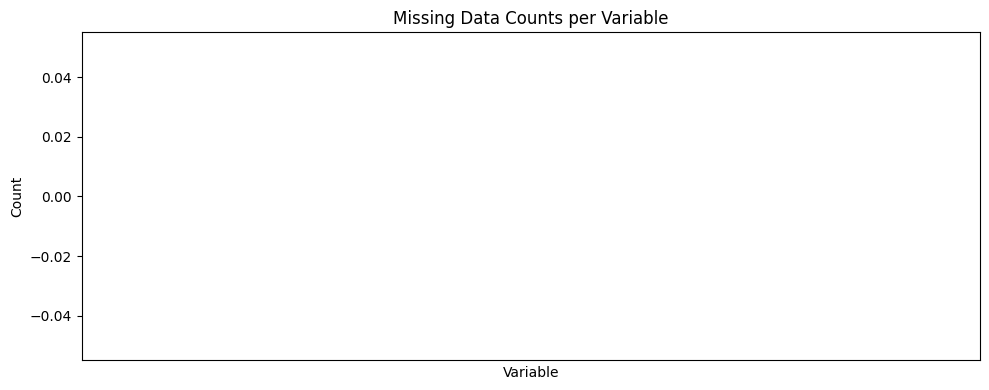

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
bar = ax.bar(
  range(len(missing_val_df)),
  height=missing_val_df["count"].values,
  color="#1eba47",
  edgecolor="black",
  tick_label=missing_val_df.index.to_list(),
  alpha=0.7)
# ax.bar_label(
#     bar,
#     **bar_label_params)
ax.set(
    xlabel="Variable",
    ylabel="Count",
    title="Missing Data Counts per Variable"
    )
# rotate_xlabels(ax)
plt.tight_layout()
plt.show()

# High-level analysis of Outliers

In [10]:
forest = IsolationForest(n_estimators = 10, random_state = 42)

In [11]:
(
    train
    .assign(outlier=forest.fit_predict(train
                                       .drop(columns="price")
                                       .select_dtypes(include="number")))
    .query("outlier == -1")
    .duration
    
)

0        90
2      1545
3        90
4        90
7       135
       ... 
633     135
634    1035
635    1400
636     535
638    1450
Name: duration, Length: 279, dtype: int64

# Pair Plots

In [12]:
def pair_plots(data,
               height=3,
               aspect=1.5,
               hue=None,
               legend=False):
  # display_html(2, "Pair Plots")

  pair_grid = sns.PairGrid(
      data=data,
      aspect=aspect,
      height=height,
      hue=hue,
      corner=True
  )
  pair_grid.map_lower(sns.scatterplot)

  if legend:
    pair_grid.add_legend()

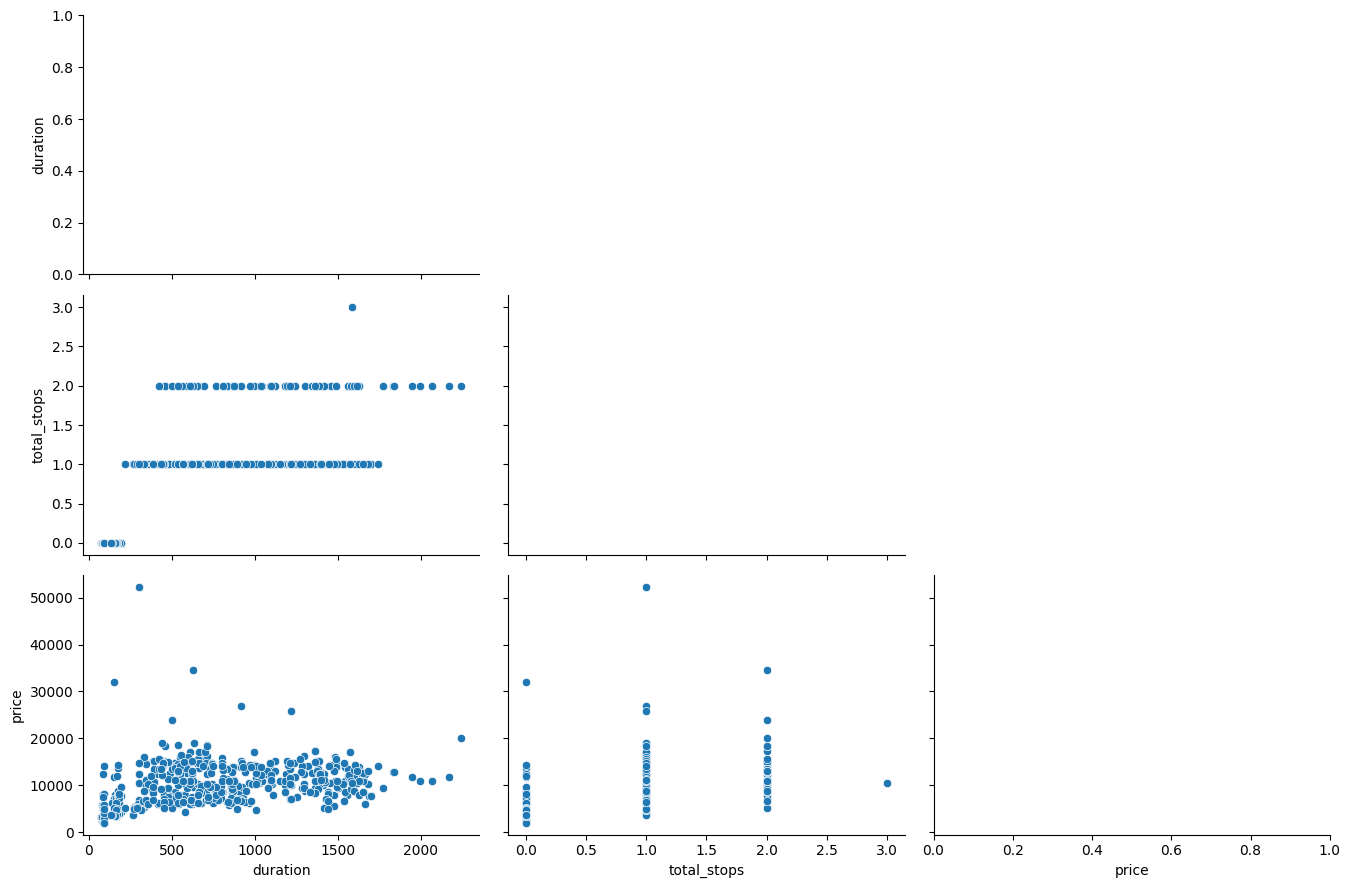

In [13]:
pair_plots(train)

## Correlation Analysis

In [57]:
def correlation_heatmap(data,
                        figsize=(12, 6),
                        method="spearman",
                        cmap="RdBu"):
  cm = data.corr(method=method, numeric_only=True)

  mask = np.zeros_like(cm, dtype=bool)
  mask[np.triu_indices_from(mask)] = True

  fig, ax = plt.subplots(figsize=figsize)
  hm = sns.heatmap(
      cm,
      vmin=-1,
      vmax=1,
      cmap=cmap,
      center=0,
      annot=True,
      fmt=".2f",
      linewidths=1.5,
      square=True,
      mask=mask,
      ax=ax
  )
#   rotate_xlabels(ax)
#   rotate_ylabels(ax)
  ax.set(title=f"{method.title()} Correlation Matrix Heatmap")

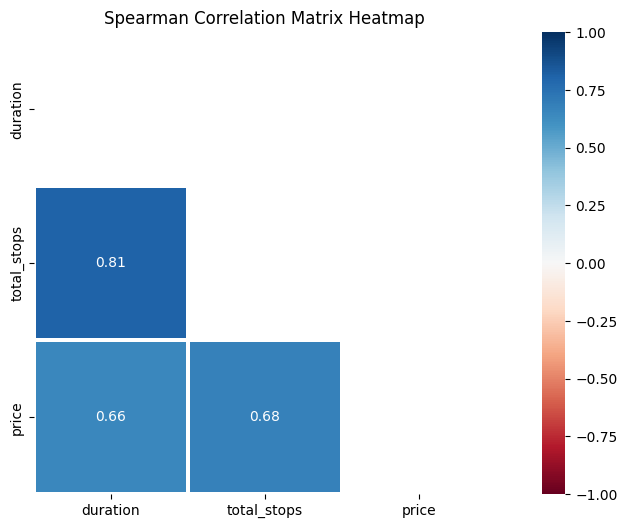

In [58]:
correlation_heatmap(train)

In [16]:
def cramers_v(data, var1, var2):
  ct = pd.crosstab(
      data.loc[:, var1],
      data.loc[:, var2]
  )
  r, c = ct.shape
  n = ct.sum().sum()
  chi2 = stats.chi2_contingency(ct).statistic
  phi2 = chi2 / n

  # bias correction
  phi2_ = max(0, phi2 - ((r - 1) * (c - 1) / (n - 1)))
  r_ = r - (((r - 1) ** 2) / (n - 1))
  c_ = c - (((c - 1) ** 2) / (n - 1))

  return np.sqrt(phi2_ / min(r_ - 1, c_ - 1))

In [55]:
def cramersV_heatmap(data, figsize=(12, 6), cmap="Blues"):
  cols = data.select_dtypes(include="O").columns.to_list()

  matrix = (
      pd
      .DataFrame(data=np.ones((len(cols), len(cols))))
      .set_axis(cols, axis=0)
      .set_axis(cols, axis=1)
  )

  for col1 in cols:
    for col2 in cols:
      if col1 != col2:
        matrix.loc[col1, col2] = cramers_v(data, col1, col2)

  mask = np.zeros_like(matrix, dtype=bool)
  mask[np.triu_indices_from(mask)] = True
  
  fig, ax = plt.subplots(figsize=figsize)
  hm = sns.heatmap(
      matrix,
      vmin=0,
      vmax=1,
      cmap=cmap,
      annot=True,
      fmt=".2f",
      square=True,
      linewidths=1.5,
      mask=mask,
      ax=ax
  )
  ax.set(title="Cramer's V Correlation Matrix Heatmap")
  # rotate_xlabels(ax)
  # rotate_ylabels(ax)

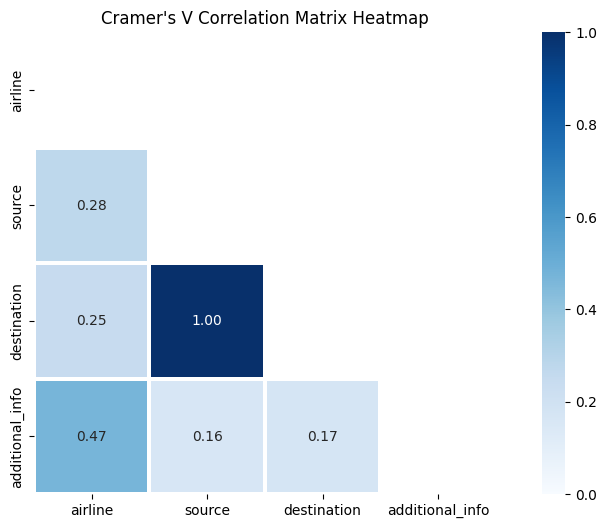

In [56]:
cramersV_heatmap(train)

# Detailed Analysis

In [19]:
train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price'],
      dtype='object')

# airline

In [20]:
train.airline

0                 Indigo
1            Jet Airways
2            Jet Airways
3                 Indigo
4                 Indigo
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638          Jet Airways
639               Indigo
Name: airline, Length: 640, dtype: object

In [21]:
eda_helper_functions.cat_summary(train, "airline")

0                 Indigo
1            Jet Airways
2            Jet Airways
3                 Indigo
4                 Indigo
             ...        
635          Jet Airways
636          Jet Airways
637    Multiple Carriers
638          Jet Airways
639               Indigo
Name: airline, Length: 640, dtype: object

Data Type      : object
Cardinality    : 8 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,8
top,Jet Airways
freq,232


,count,percentage
category,,
Jet Airways,232,0.362500
Indigo,137,0.214062
Air India,94,0.146875
Multiple Carriers,74,0.115625
Spicejet,53,0.082812
Vistara,22,0.034375
Air Asia,17,0.026562
Goair,11,0.017188


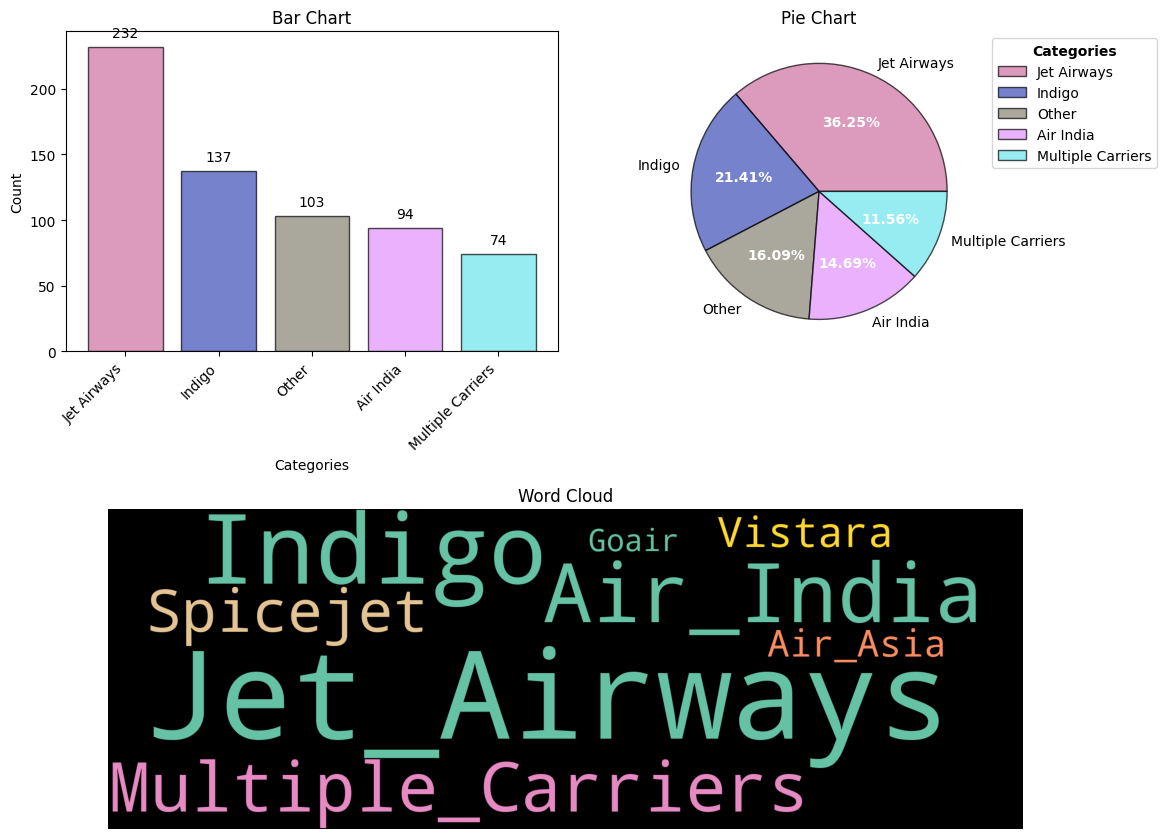

In [22]:
eda_helper_functions.cat_univar_plots(train, "airline", k=4)

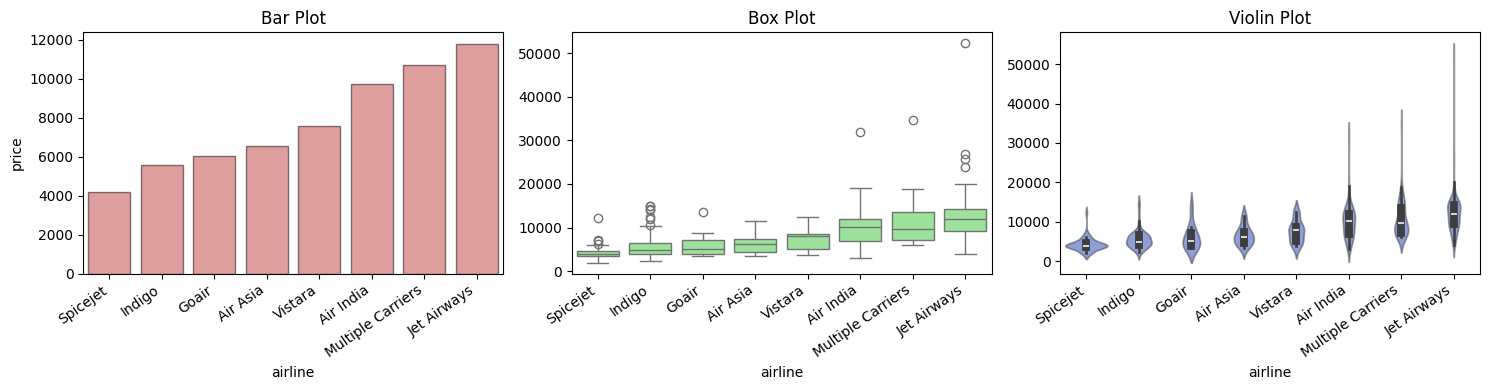

In [23]:
eda_helper_functions.num_cat_bivar_plots(
    data=train,
    num_var="price",
    cat_var="airline"
)

In [24]:
eda_helper_functions.num_cat_hyp_testing(train, "price", "airline")

- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population mean
- Alternate Hypothesis : The groups don't have similar population mean
- Test Statistic       : 50.89786489446408
- p-value              : 1.887210262773428e-57
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


- Significance Level   : 5.0%
- Null Hypothesis      : The groups have similar population median
- Alternate Hypothesis : The groups don't have similar population median
- Test Statistic       : 307.71728368096797
- p-value              : 1.3593687741758414e-62
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and airline are associated to each other


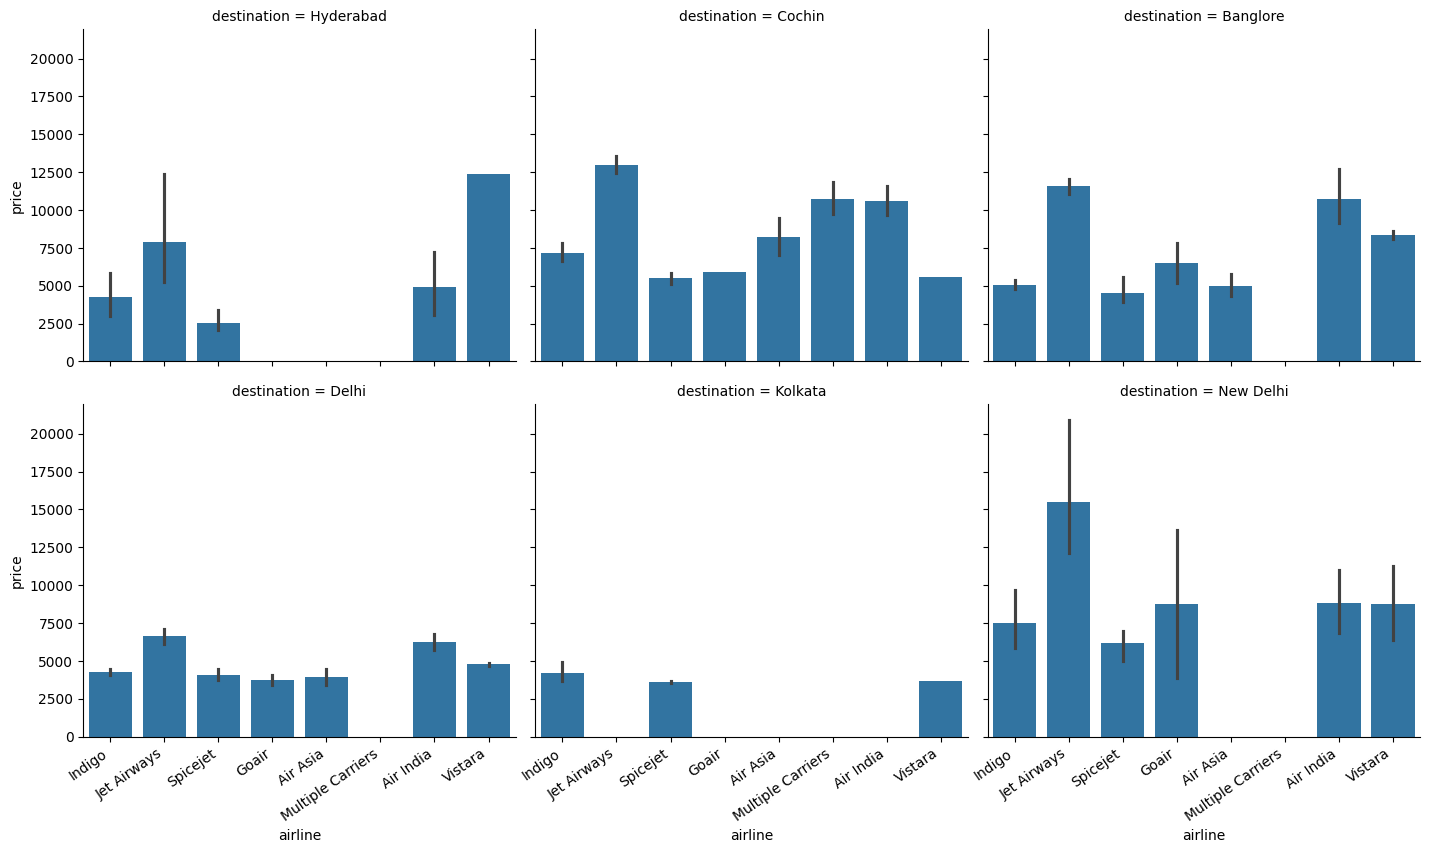

In [25]:
airline_grid = sns.FacetGrid(
    data=train,
    col="destination",
    col_wrap=3,
    height=4,
    aspect=1.2,
    sharey=True
)

airline_grid.map(sns.barplot, "airline", "price", order=train.airline.unique())

for ax in airline_grid.axes[3:]:
    eda_helper_functions.rotate_xlabels(ax)

# Date of Journey

In [26]:
train.date_of_journey

0     2019-06-27
1     2019-03-03
2     2019-05-18
3     2019-06-01
4     2019-03-01
         ...    
635   2019-03-03
636   2019-06-09
637   2019-06-15
638   2019-05-12
639   2019-06-09
Name: date_of_journey, Length: 640, dtype: datetime64[ns]

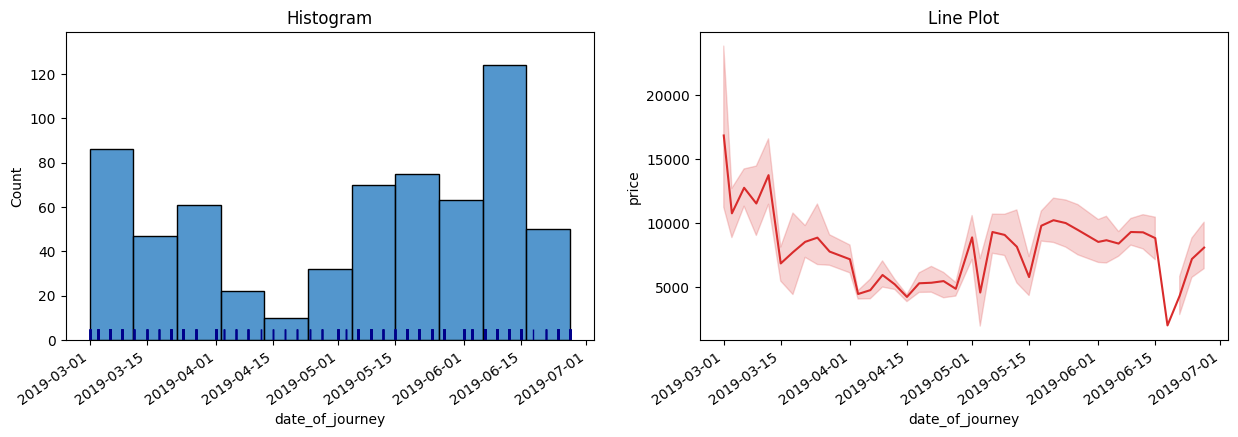

In [27]:
eda_helper_functions.dt_univar_plots(
    data=train,
    var="date_of_journey",
    target="price"
)

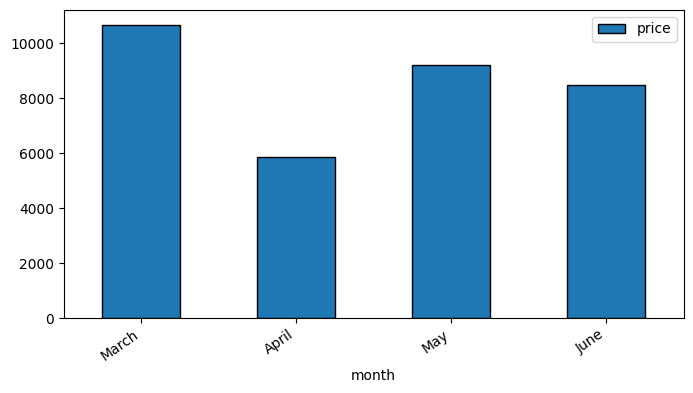

In [28]:
(
    train
    .groupby(pd.Grouper(key = "date_of_journey", freq = "M"))
    .price.mean()
    .to_frame()
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="month")
    .plot(
        kind="bar",
        figsize=(8,4),
        edgecolor = "black"
    )
)
ax=plt.gca()
eda_helper_functions.rotate_xlabels(ax)

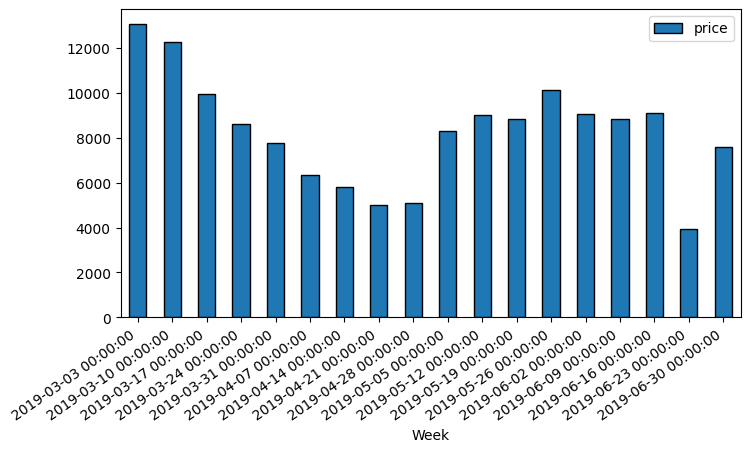

In [29]:
(
    train
    .groupby(pd.Grouper(key = "date_of_journey", freq = "W"))
    .price.mean()
    .to_frame()
    # .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="Week")
    .plot(
        kind="bar",
        figsize=(8,4),
        edgecolor = "black"
    )
)
ax=plt.gca()
eda_helper_functions.rotate_xlabels(ax)

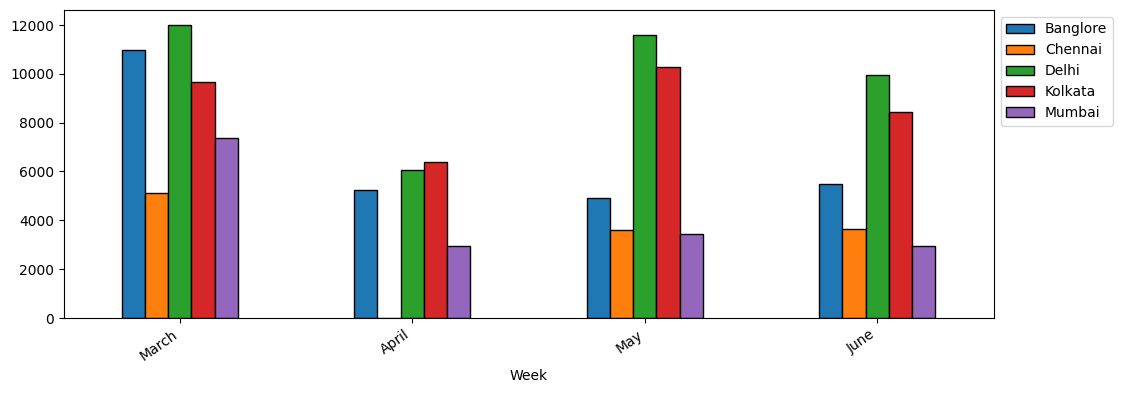

In [30]:
(
    train
    .groupby([pd.Grouper(key="date_of_journey", freq="M"), "source"])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(["March", "April", "May", "June"], axis=0)
    .rename_axis(index="Week")
    .plot(
        kind="bar",
        figsize=(12,4),
        edgecolor = "black"
        )
)
ax = plt.gca()
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
eda_helper_functions.rotate_xlabels(ax)

# Dep Time

In [31]:
train.dep_time

0     2024-05-30 21:20:00
1     2024-05-30 09:55:00
2     2024-05-30 16:30:00
3     2024-05-30 06:25:00
4     2024-05-30 09:10:00
              ...        
635   2024-05-30 05:45:00
636   2024-05-30 19:30:00
637   2024-05-30 18:15:00
638   2024-05-30 09:35:00
639   2024-05-30 16:00:00
Name: dep_time, Length: 640, dtype: datetime64[ns]

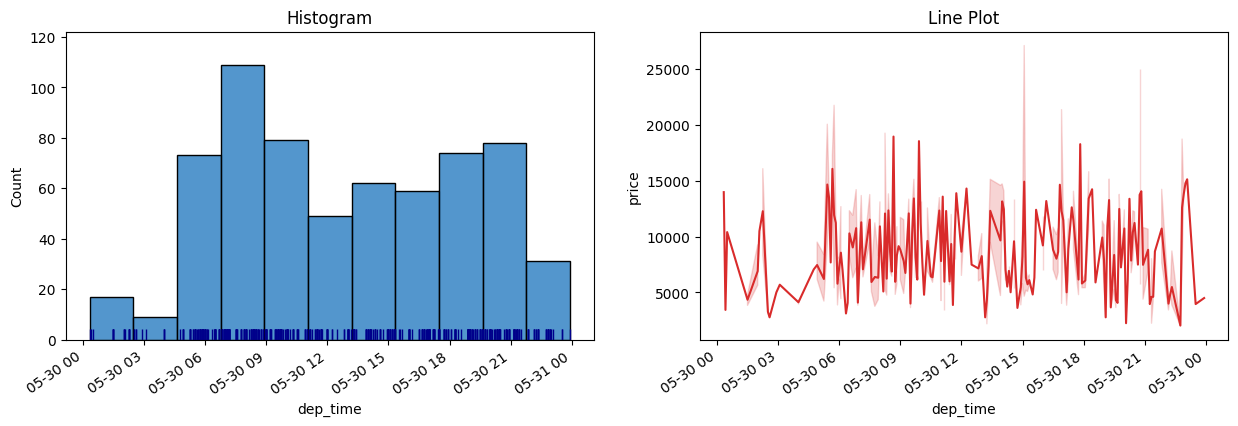

In [32]:
eda_helper_functions.dt_univar_plots(train, "dep_time", "price")

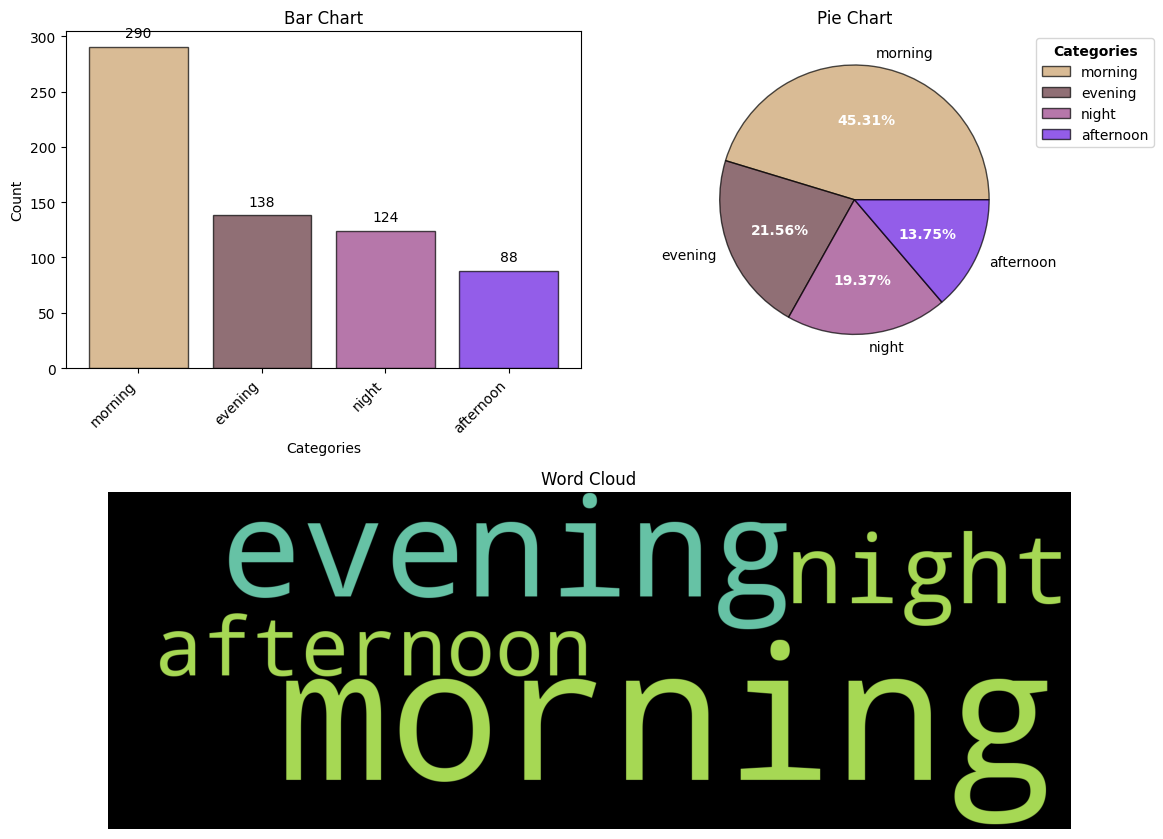

In [35]:
(
    train
    .assign(dep_time = lambda df_: (np.select([df_.dep_time.dt.hour.between(4,12, inclusive="left"),
                                               df_.dep_time.dt.hour.between(12,16, inclusive="left"),
                                               df_.dep_time.dt.hour.between(16,20, inclusive="left"),],
                                               ["morning", "afternoon", "evening"],
                                               default="night")))
    .pipe(eda_helper_functions.cat_univar_plots, "dep_time")

)


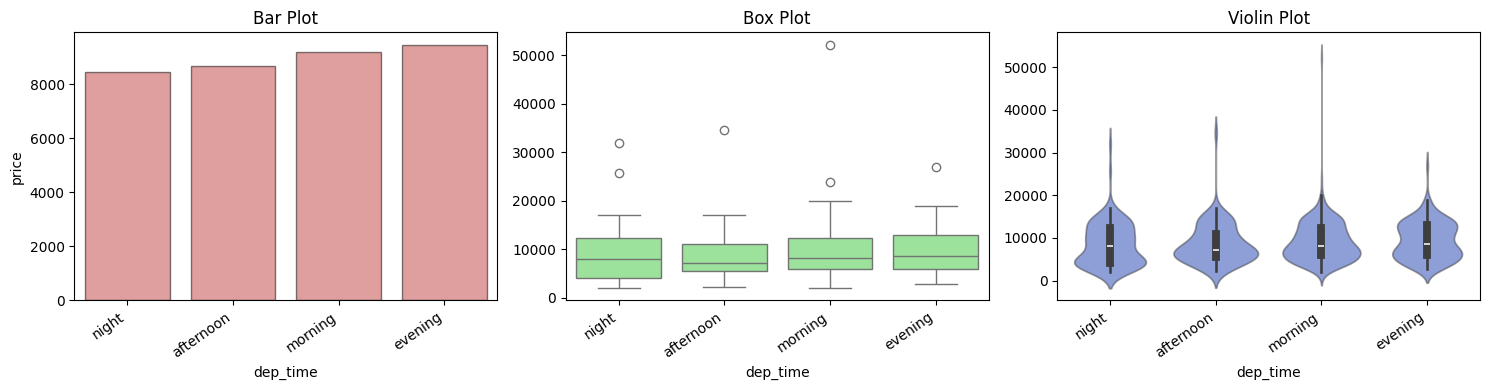

In [36]:
(
    train
    .assign(dep_time = lambda df_: (np.select([df_.dep_time.dt.hour.between(4,12, inclusive="left"),
                                               df_.dep_time.dt.hour.between(12,16, inclusive="left"),
                                               df_.dep_time.dt.hour.between(16,20, inclusive="left"),],
                                               ["morning", "afternoon", "evening"],
                                               default="night")))
    .pipe(eda_helper_functions.num_cat_bivar_plots, "price", "dep_time")

)

# Duration

In [37]:
train.duration

0        90
1       535
2      1545
3        90
4        90
       ... 
635    1400
636     535
637     435
638    1450
639     570
Name: duration, Length: 640, dtype: int64

In [38]:
eda_helper_functions.num_summary(train, "duration")

0        90
1       535
2      1545
3        90
4        90
       ... 
635    1400
636     535
637     435
638    1450
639     570
Name: duration, Length: 640, dtype: int64

Data Type      : int64
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,value
percentile,
0,75.00
5,90.00
10,145.00
25,175.00
50,540.00
75,941.25
90,1440.00
95,1580.25
99,1808.55


,value
mean,646.093750
trimmed mean (5%),616.979167
trimmed mean (10%),592.099609
median,540.000000


,value
var,247430.022496
std,497.423384
IQR,766.250000
mad,370.000000
coef_variance,0.769894


,value
skewness,0.749154
kurtosis,-0.480837


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
p-value              : 2.279333174835234e-20
Test Statistic       : 0.8963142037391663
- Since p-value is less than alpha (0.05), we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


Significance Level   : 0.05
Null Hypothesis      : The data is normally distributed
Alternate Hypothesis : The data is not normally distributed
Critical Value       : 0.782
Test Statistic       : 21.771278014504787
- Since the Test-statistic is greater than Critical Value, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: We conclude that the data sample is not normally distributed


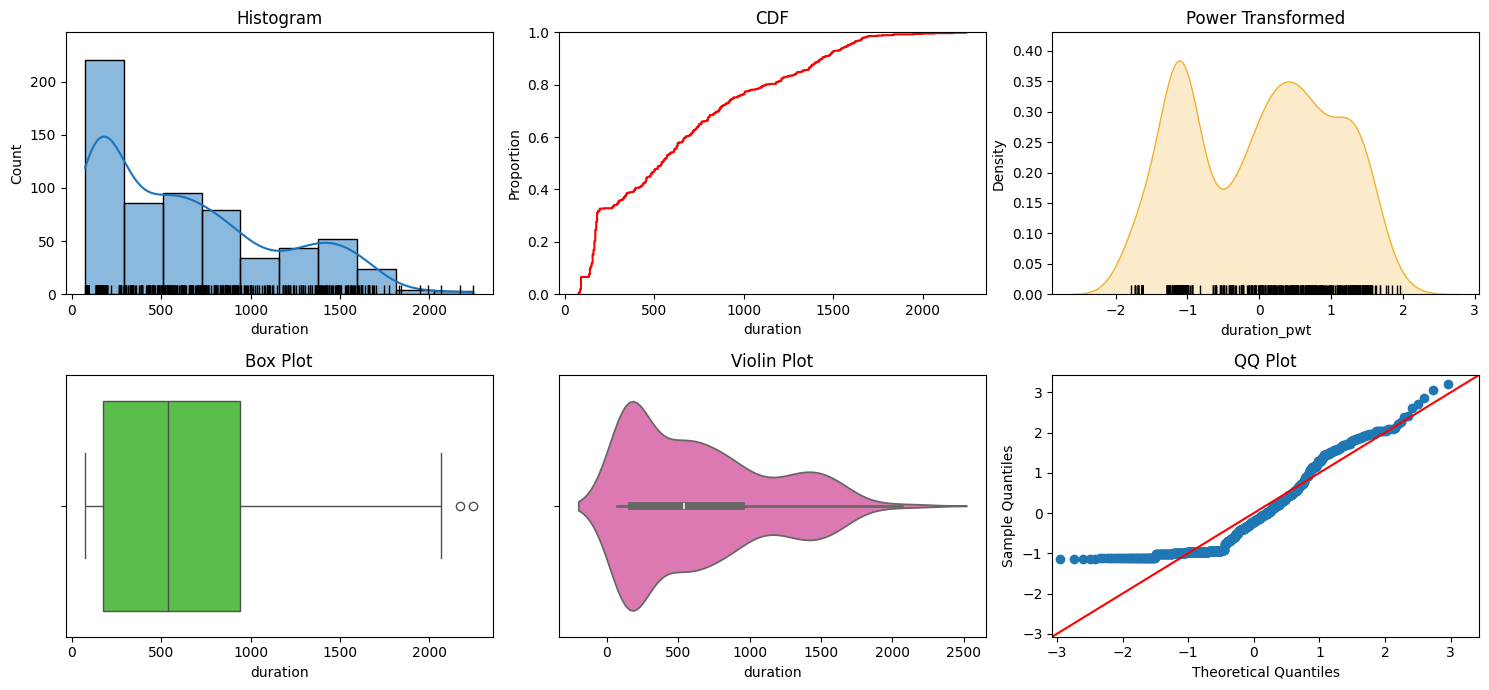

In [39]:
eda_helper_functions.num_univar_plots(train, "duration")

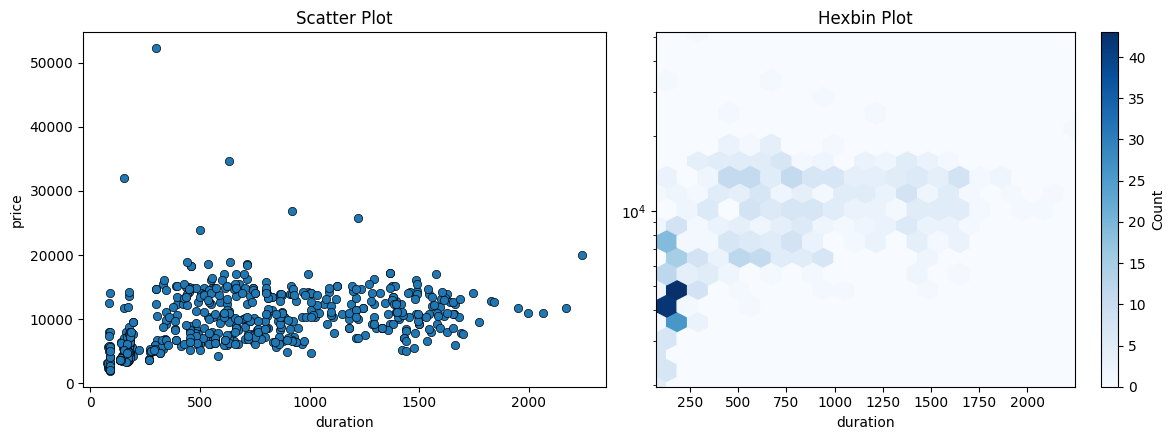

In [43]:
eda_helper_functions.num_bivar_plots(
    train,
    "duration",
    "price",
    hexbin_kwargs=dict(
        yscale = "log",
        gridsize = 20,
        cmap = "Blues"
    )
)

In [44]:
eda_helper_functions.num_num_hyp_testing(train, "price", "duration")

- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.4606737685753876
- p-value              : 6.117941861764596e-35
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


- Significance Level   : 5.0%
- Null Hypothesis      : The samples are uncorrelated
- Alternate Hypothesis : The samples are correlated
- Test Statistic       : 0.6561745628347071
- p-value              : 4.657143380669305e-80
- Since p-value is less than 0.05, we Reject the Null Hypothesis at 5.0% significance level
- CONCLUSION: The variables price and duration are correlated


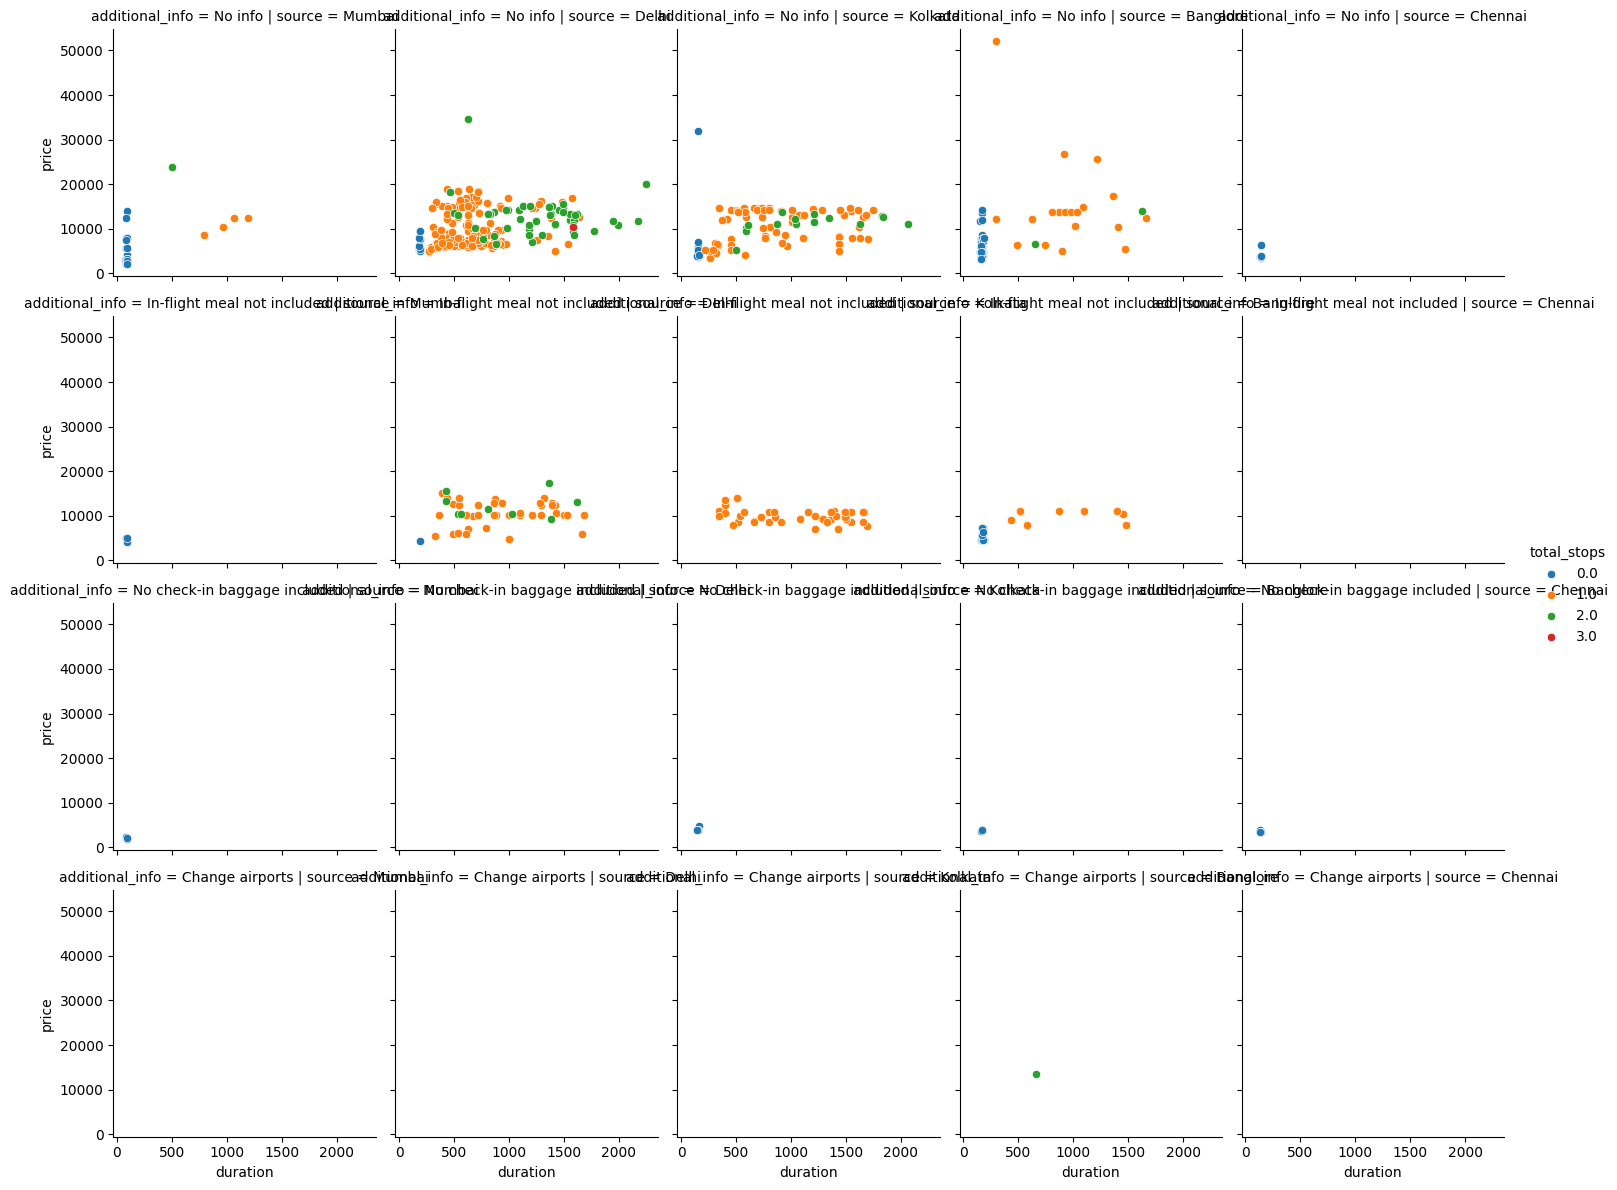

In [49]:
duration_grid = sns.FacetGrid(
    data=train,
    col = "source",
    row = "additional_info",
    hue = "total_stops",
    sharey=True
)
duration_grid.map(sns.scatterplot, "duration", "price")
duration_grid.add_legend()

# Automated EDA

In [51]:
from ydata_profiling import ProfileReport

In [52]:
report = ProfileReport(train)

In [54]:
report.to_file(output_file="output.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 491.54it/s]


In [61]:
eda_helper_functions.get_iqr_outliers(train, "duration")

Lower Limit : -974.375
Upper Limit : 2090.625


,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
51,Air India,2019-03-03,Delhi,Cochin,2024-05-30 07:05:00,2024-05-30 19:15:00,2170,2.0,No info,11762
440,Jet Airways,2019-03-03,Delhi,Cochin,2024-05-30 05:25:00,2024-05-30 18:50:00,2245,2.0,No info,20064


In [62]:
eda_helper_functions.cat_summary(train, "additional_info")

0                          No info
1                          No info
2      In-flight meal not included
3                          No info
4                          No info
                  ...             
635    In-flight meal not included
636                        No info
637                        No info
638                        No info
639                        No info
Name: additional_info, Length: 640, dtype: object

Data Type      : object
Cardinality    : 4 categories
Missing Data   : 0 rows (0.00 %)
Available Data : 640 / 640 rows


,
count,640
unique,4
top,No info
freq,501


,count,percentage
category,,
No info,501,0.782813
In-flight meal not included,117,0.182812
No check-in baggage included,21,0.032813
Change airports,1,0.001563
